In [9]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

#set up
import torch, detectron2
print("detectron2:", detectron2.__version__)

from detectron2.utils.logger import setup_logger
setup_logger()

# import common libraries
import numpy as np
import os, json, cv2, random

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt

%matplotlib inline

/bin/bash: nvcc: command not found
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6
detectron2: 0.6


In [10]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [11]:
register_coco_instances("guard_train", {}, "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg4/train/_annotations.coco.json", "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg4/train/")
register_coco_instances("guard_valid", {}, "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg4/valid/_annotations.coco.json", "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg4/valid/")

In [13]:
dataset_dicts = get_detection_dataset_dicts(["guard_train"])
_dataset_metadata = MetadataCatalog.get("guard_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

WARNING [12/05 16:27:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/05 16:27:55 d2.data.datasets.coco]: Loaded 18 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg4/train/_annotations.coco.json
[12/05 16:27:55 d2.data.build]: Removed 0 images with no usable annotations. 18 images left.
3 Number of classes in the dataset


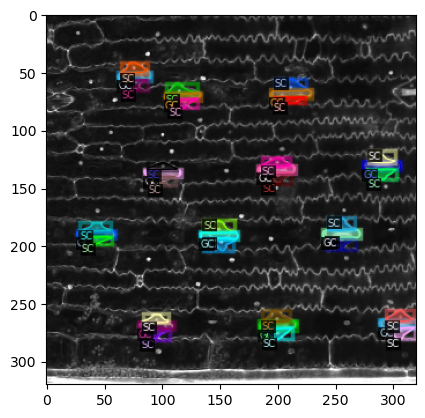

In [6]:
###check the dataset and annotation

for d in random.sample(dataset_dicts, 3):
    if '\\' in d['file_name']:
        d['file_name'] = d['file_name'].replace('\\','/')
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [7]:
### Train the model
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("guard_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =  2 #@param
cfg.SOLVER.BASE_LR = 0.00025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 2000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)



[12/05 15:06:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/lliu4_umass_edu/.conda/envs/GuardSeg/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/lliu4_umass_edu/.conda/envs/GuardSeg/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024)

In [9]:
## trainer.train()

In [8]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. 
# We simply update the weights with the newly trained ones to perform inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/output/model_final.pth")  # path to the model we just trained
# set a custom testing threshold

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 #@param {type: "slider", min:0.0, max:1.0, step: 0.01}
predictor = DefaultPredictor(cfg)

[12/05 15:07:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/output/model_final.pth ...


In [9]:
from detectron2.utils.visualizer import ColorMode

WARNING [12/05 15:07:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/05 15:07:09 d2.data.datasets.coco]: Loaded 5 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg4/valid/_annotations.coco.json
[12/05 15:07:09 d2.data.build]: Removed 0 images with no usable annotations. 5 images left.
[12/05 15:07:09 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   GC-SC    | 0            |     GC     | 65           |     SC     | 130          |
|            |              |            |              |            |              |
|   total    | 195          |            |              |            |              |


/home/lliu4_umass_edu/.conda/envs/GuardSeg/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343899977/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


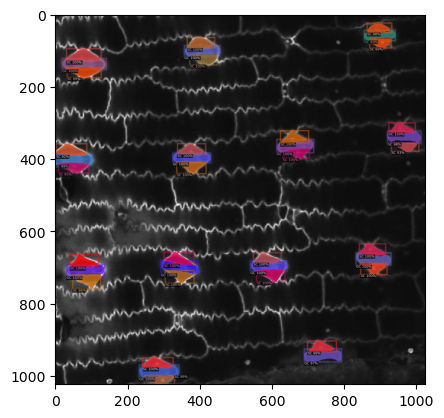

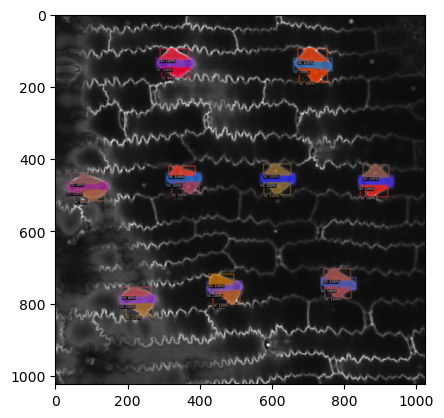

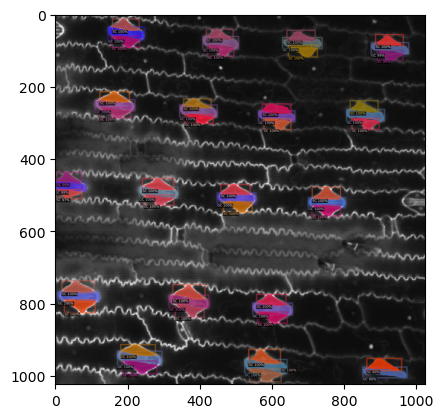

In [10]:
dataset_dicts = get_detection_dataset_dicts(["guard_valid"])
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=_dataset_metadata, 
                   scale=1.6, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
        

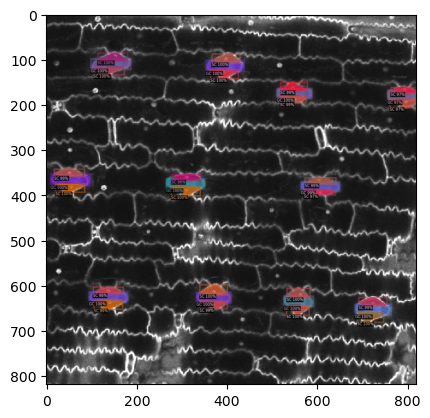

In [11]:
###Random select one image for detect
im = cv2.imread("NC358_1.png")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=_dataset_metadata, 
               scale=1.6, 
               instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()





In [15]:
data_path =  './GuardSeg4/train'
filelist=[file for file in os.listdir(data_path) if file.endswith('.jpg')]
print(filelist)
text = []
for text in filelist:
    res = text.split('_')[0]
    print(res)

['CML103_1-czi_png.rf.2a9f79464b3e415dab150663351feee1.jpg', 'CML103_3-czi_png.rf.f2495f7b935d714143acbf40715bfe20.jpg', 'CML103_4-czi_png.rf.73f96355502d229cec1c176500c37fae.jpg', 'CML103_5-czi_png.rf.70eb2b593f3d139b358f088dfeeb028f.jpg', 'CML228_2-czi_png.rf.1f80448e2a33e8424a6f5417e3731e6f.jpg', 'CML228_4-czi_png.rf.c0f1f174b379902e98f359a5464a512c.jpg', 'CML228_5-czi_png.rf.01978665d3295930b121695f4dba96d3.jpg', 'CML228_6-czi_png.rf.30fdbfc1de733b8ed8c8a77c114d79fc.jpg', 'Mo17_1-czi_png.rf.1a586cf5a19132e0807842900d259222.jpg', 'Mo17_2-czi_png.rf.e46c933c663661e85d72a9a270dd93f5.jpg', 'Mo17_5-czi_png.rf.5161c442f12a0bb6bcb816c585d211ef.jpg', 'NC358_3-czi_png.rf.75d34cb15b8dc0361209b1fce8600f2a.jpg', 'NC358_5-czi_png.rf.f84ca3b77d753e22f43f7f8d963d52e1.jpg', 'P39Gb_1-czi_png.rf.e06270a63ab785b9ffa509ab290dcd73.jpg', 'P39Gb_2-czi_png.rf.eed856a02ad305d3a1eac93daa944119.jpg', 'P39Gb_3-czi_png.rf.1e534d8ca0a60a8509beb784662a365b.jpg', 'P39Gb_5-czi_png.rf.1da5f23216c8774dc8bee658662f7d

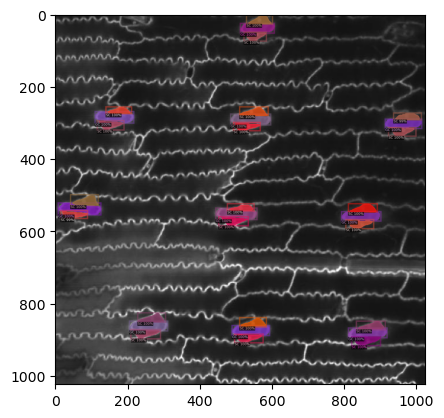

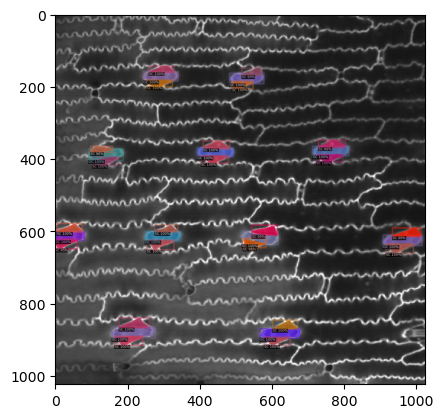

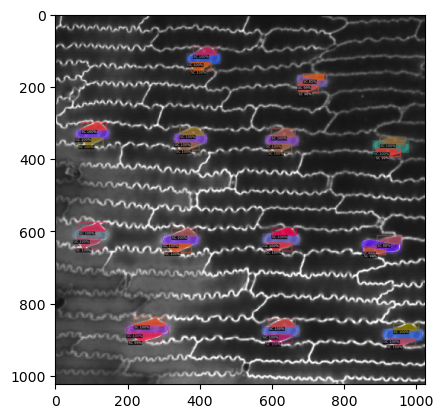

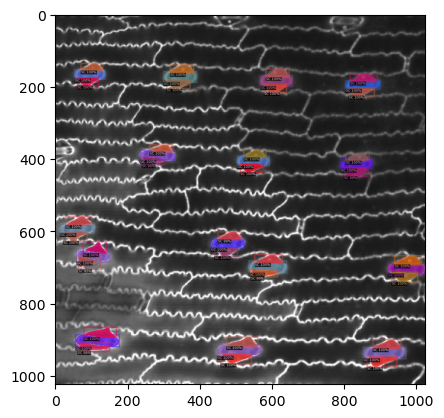

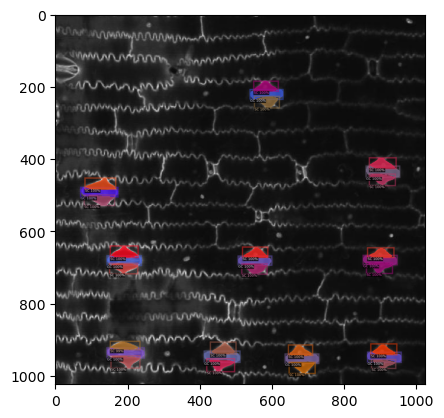

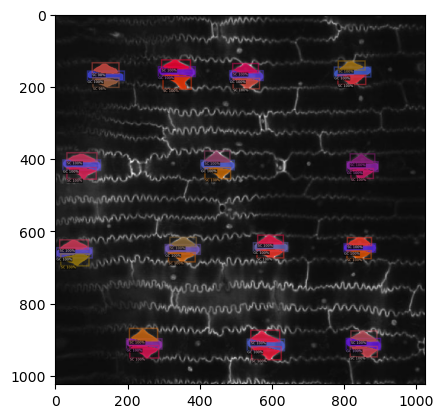

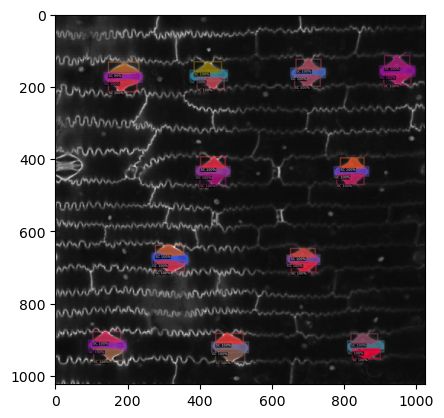

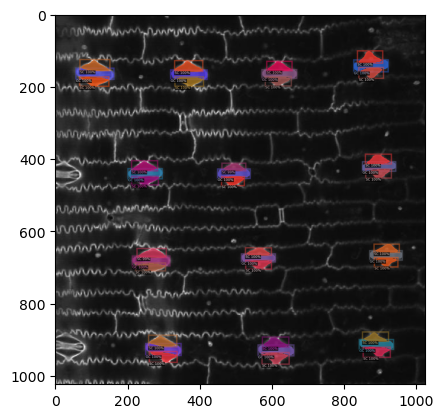

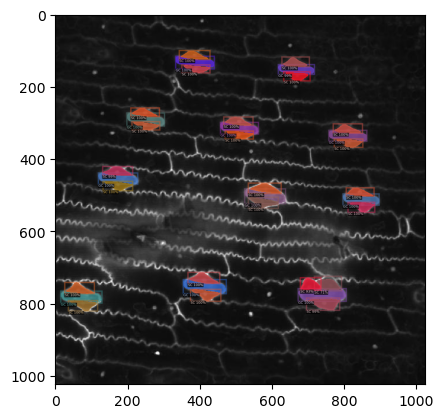

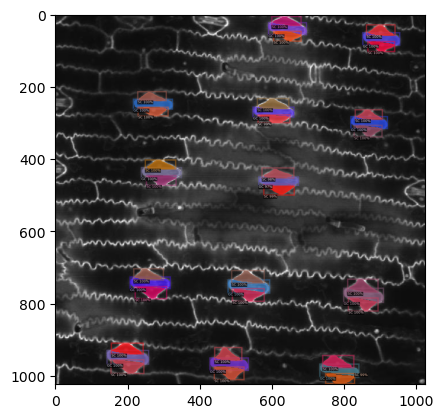

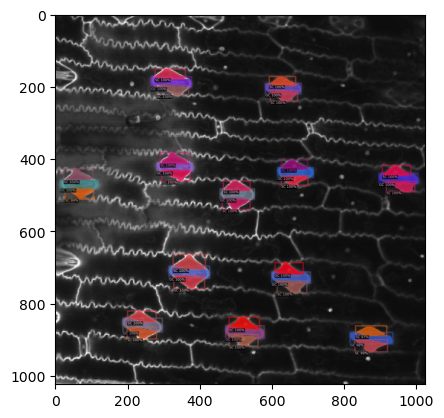

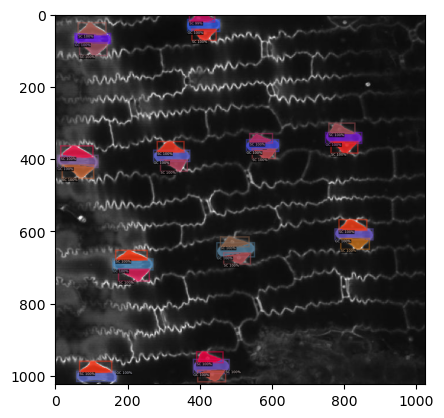

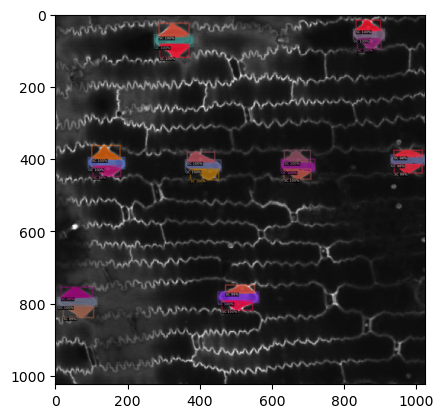

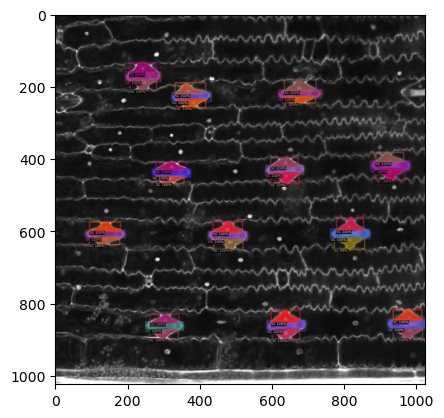

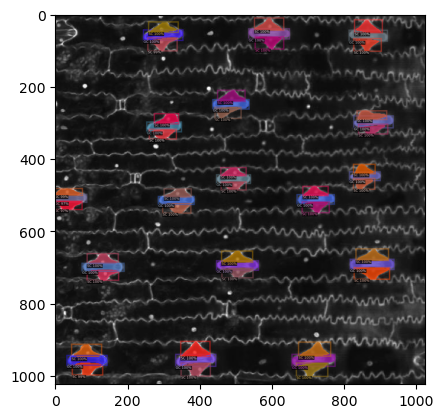

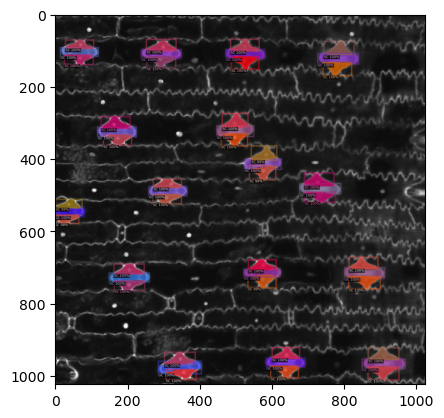

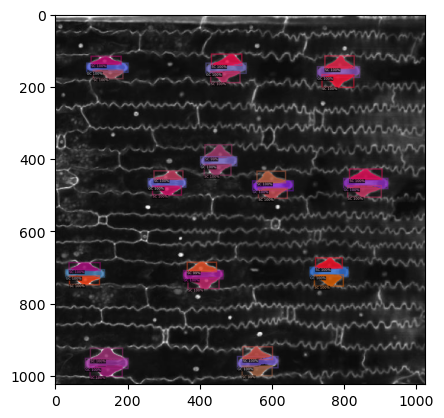

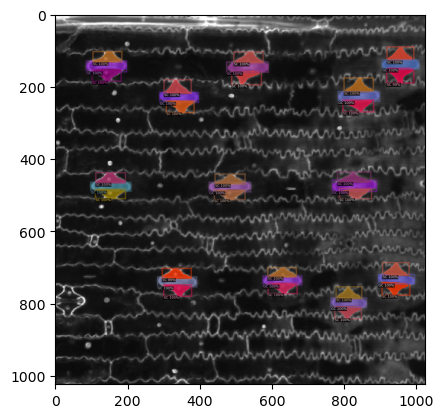

In [16]:
###

# os.chdir('./GuardSeg4/train/')

output_lists = []

for file in filelist:
    im = cv2.imread(file)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
               metadata=_dataset_metadata, 
               scale=1.6, 
               instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    outputs ['genotype'] = file.split('_')[0]
    outputs ['date'] = '3weeks'
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    output_lists.append(outputs)



In [41]:
import numpy as np
import pandas as pd

# Create empty DataFrames
data_sc = {'Genotype': [], 'sc_instance': []}
data_gc = {'Genotype': [], 'gc_instance': []}

# Assuming you have 'output_lists' containing 'predictions'
for predictions in output_lists:
    pred_boxes = predictions['instances'].pred_boxes.tensor.cpu().numpy()
    scores = predictions['instances'].scores.cpu().numpy()
    pred_classes = predictions['instances'].pred_classes.cpu().numpy()
    pred_masks = predictions['instances'].pred_masks.cpu().numpy()
    genotype = predictions['genotype']

    # Filter by class (assuming class IDs 1 for GC and 2 for SC)
    gc_indices = np.where(pred_classes == 1)[0]
    sc_indices = np.where(pred_classes == 2)[0]

    # Add individual instance information to the DataFrame for SC
    for sc_idx in sc_indices:
        sc_instance = {
            'Genotype': genotype,
            'sc_area': pred_masks[sc_idx].sum().item(),
            'sc_length': pred_boxes[sc_idx, 2] - pred_boxes[sc_idx, 0],
            'sc_width': pred_boxes[sc_idx, 3] - pred_boxes[sc_idx, 1]
        }
        data_sc['Genotype'].append(sc_instance['Genotype'])
        data_sc['sc_instance'].append(sc_instance)

    # Add individual instance information to the DataFrame for GC
    for gc_idx in gc_indices:
        gc_instance = {
            'Genotype': genotype,
            'gc_area': pred_masks[gc_idx].sum().item() / 2,
            'gc_length': pred_boxes[gc_idx, 2] - pred_boxes[gc_idx, 0],
            'gc_width': pred_boxes[gc_idx, 3] - pred_boxes[gc_idx, 1]
        }
        data_gc['Genotype'].append(gc_instance['Genotype'])
        data_gc['gc_instance'].append(gc_instance)


# Convert the dictionaries to DataFrames
df_sc = pd.DataFrame(data_sc)
df_gc = pd.DataFrame(data_gc)

# Extract values into separate columns
df = df_sc
df['Genotype'] = df['sc_instance'].apply(lambda x: x['Genotype'])
df['sc_area'] = df['sc_instance'].apply(lambda x: x['sc_area'])
df['sc_length'] = df['sc_instance'].apply(lambda x: x['sc_length'])
df['sc_width'] = df['sc_instance'].apply(lambda x: x['sc_width'])

# Drop the original 'sc_instance' column
df.drop('sc_instance', axis=1, inplace=True)

# Print the resulting DataFrame
print(df)
df.to_csv('SCarea2.csv', index=False)

# Extract values into separate columns
df = df_gc
df['Genotype'] = df['gc_instance'].apply(lambda x: x['Genotype'])
df['gc_area'] = df['gc_instance'].apply(lambda x: x['gc_area'])
df['gc_length'] = df['gc_instance'].apply(lambda x: x['gc_length'])
df['gc_width'] = df['gc_instance'].apply(lambda x: x['gc_width'])

# Drop the original 'sc_instance' column
df.drop('gc_instance', axis=1, inplace=True)

# Print the resulting DataFrame
print(df)
df.to_csv('GCarea2.csv', index=False)



    Genotype  sc_area  sc_length   sc_width
0     CML103      373  38.729950  15.673132
1     CML103      380  45.504700  15.389145
2     CML103      470  49.843384  15.416443
3     CML103      396  49.994690  14.964417
4     CML103      428  47.474304  15.430298
..       ...      ...        ...        ...
437    P39Gb      502  50.584656  18.500694
438    P39Gb      467  52.250702  15.916382
439    P39Gb      531  46.818588  23.760651
440    P39Gb      467  49.800232  17.306915
441    P39Gb      655  46.728210  26.301468

[442 rows x 4 columns]
    Genotype  gc_area  gc_length   gc_width
0     CML103    365.0  58.953613  17.209267
1     CML103    441.5  69.528900  19.072540
2     CML103    410.0  67.092102  16.879089
3     CML103    431.5  66.223099  17.034790
4     CML103    421.5  65.239197  17.098816
..       ...      ...        ...        ...
216    P39Gb    367.0  61.150116  16.110046
217    P39Gb    351.0  66.868561  15.381165
218    P39Gb    466.5  72.052460  17.563515
219    P

In [22]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

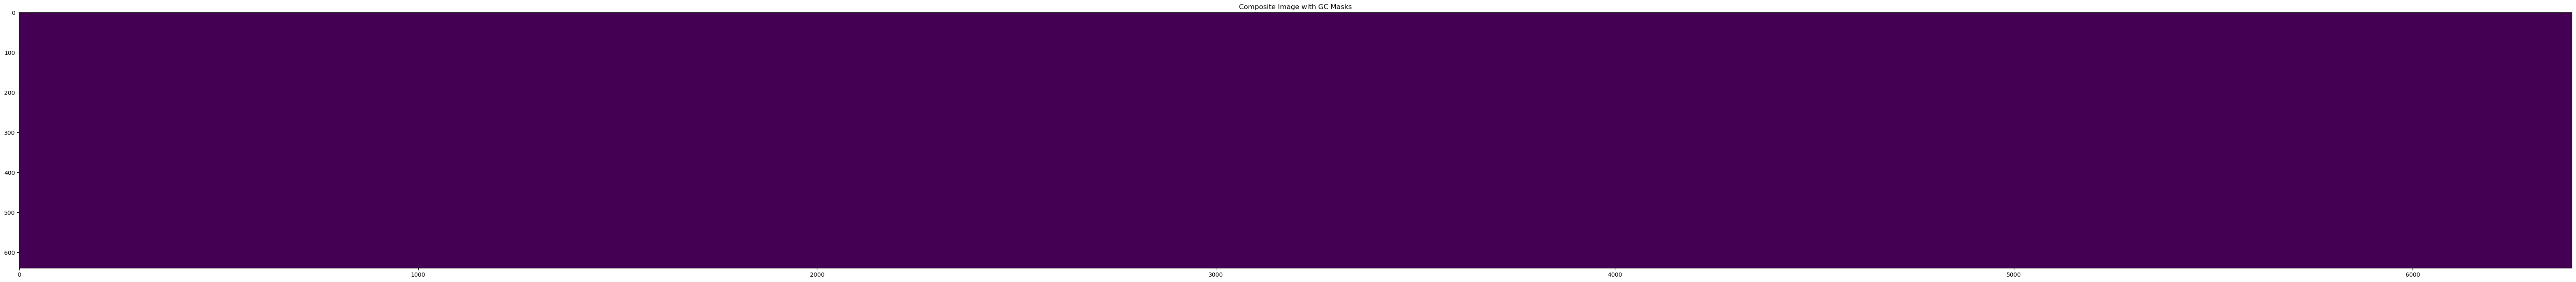

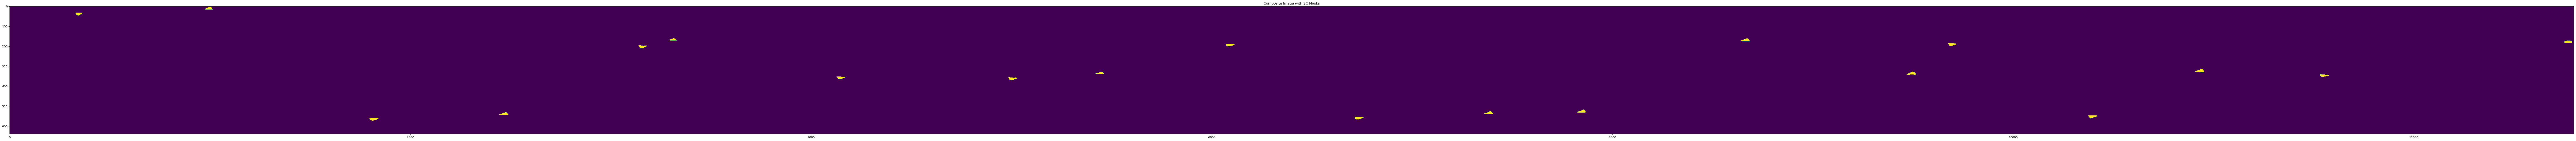

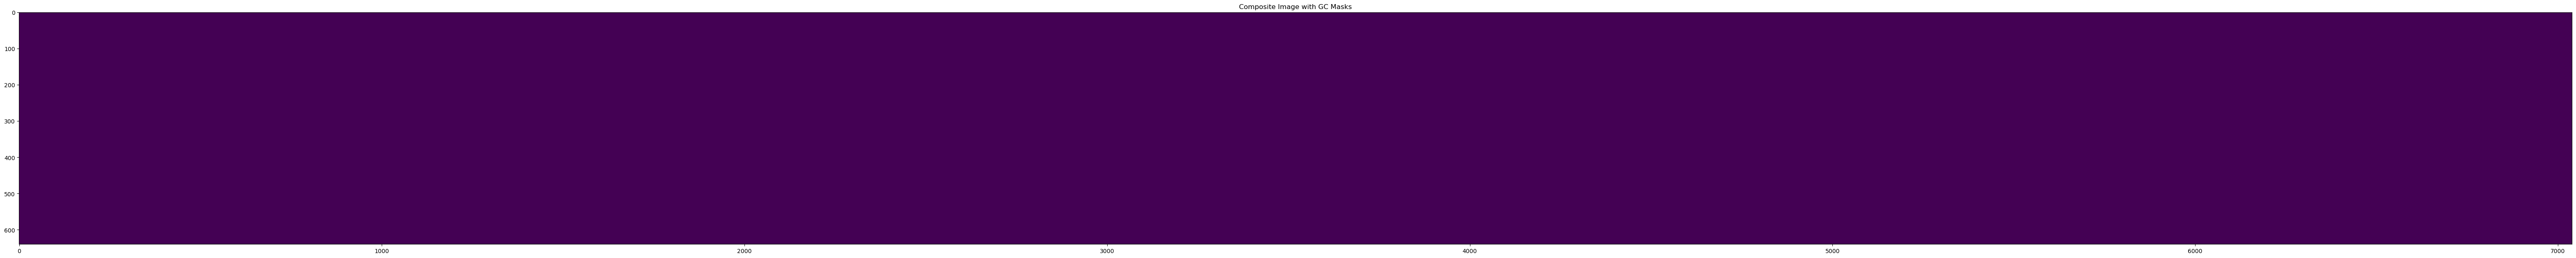

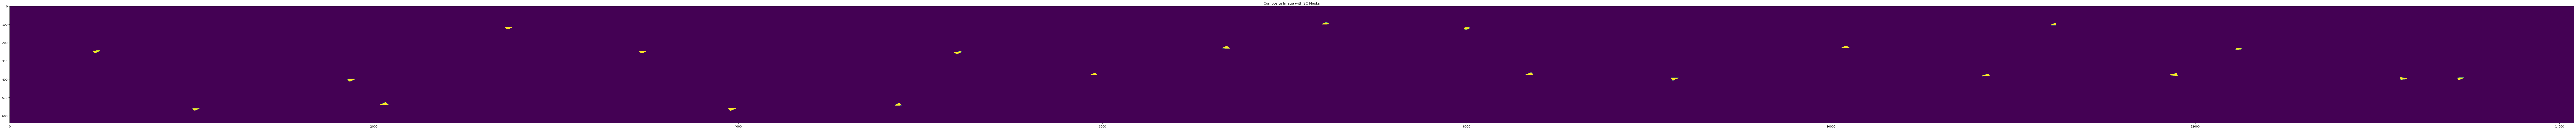

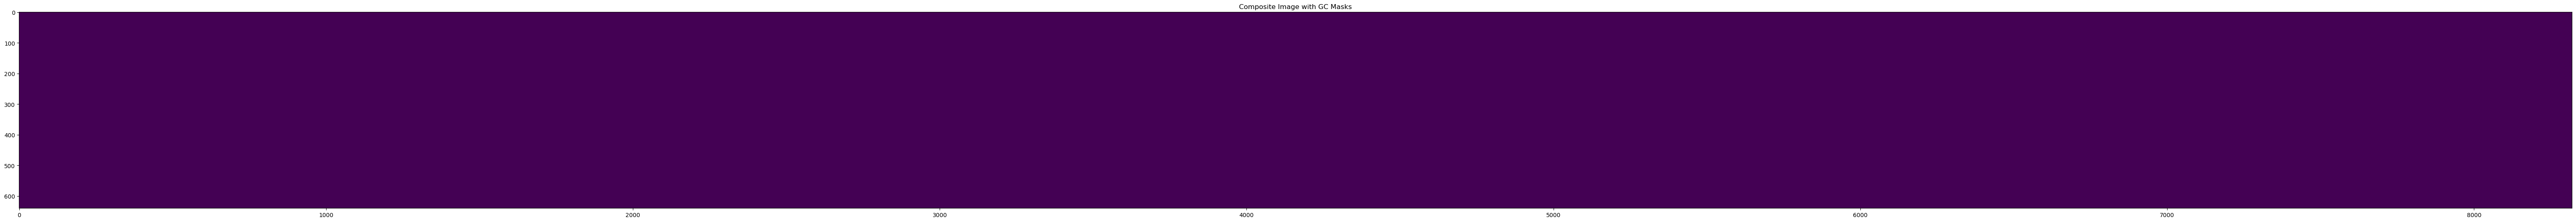

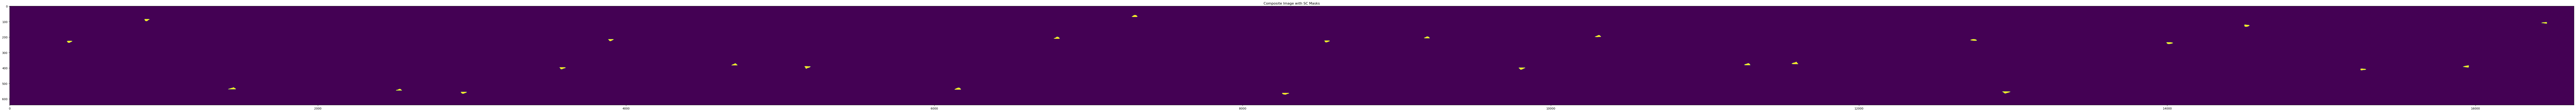

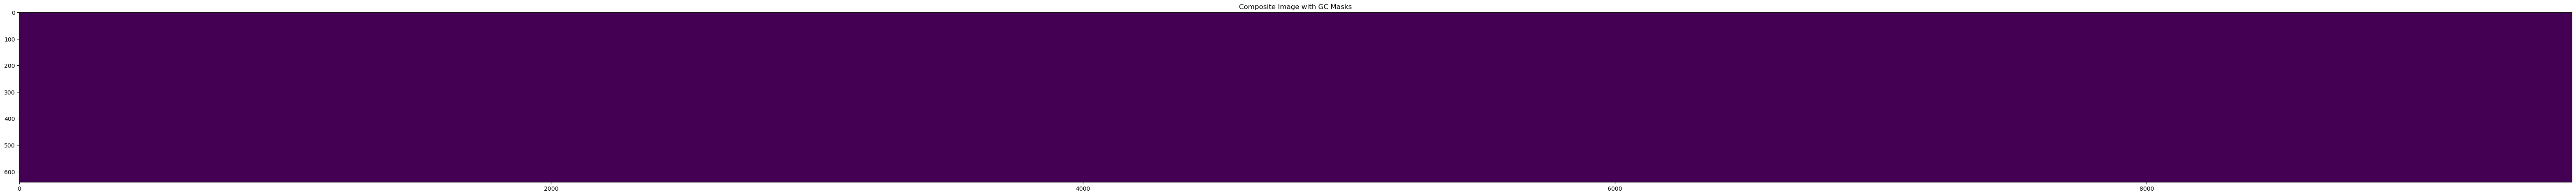

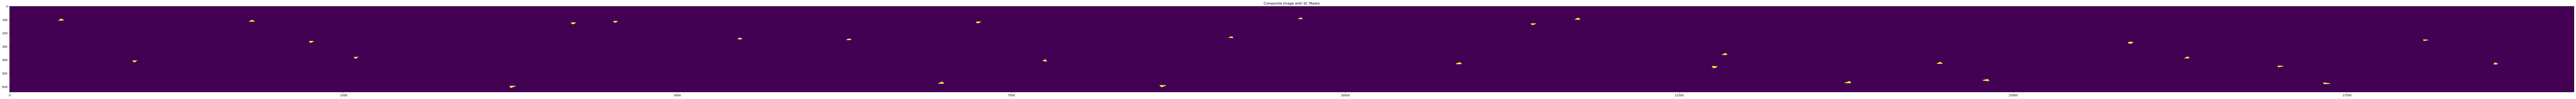

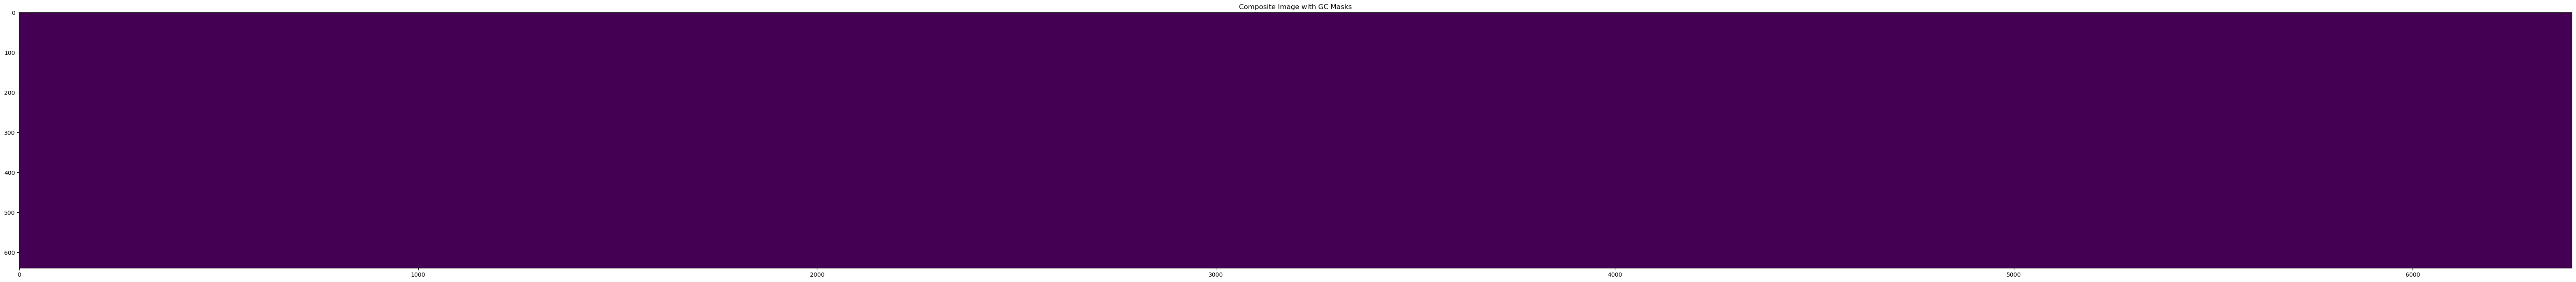

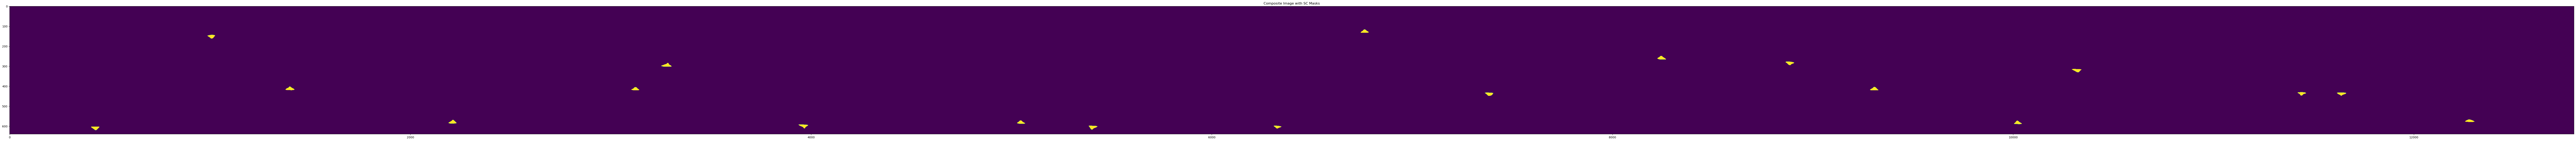

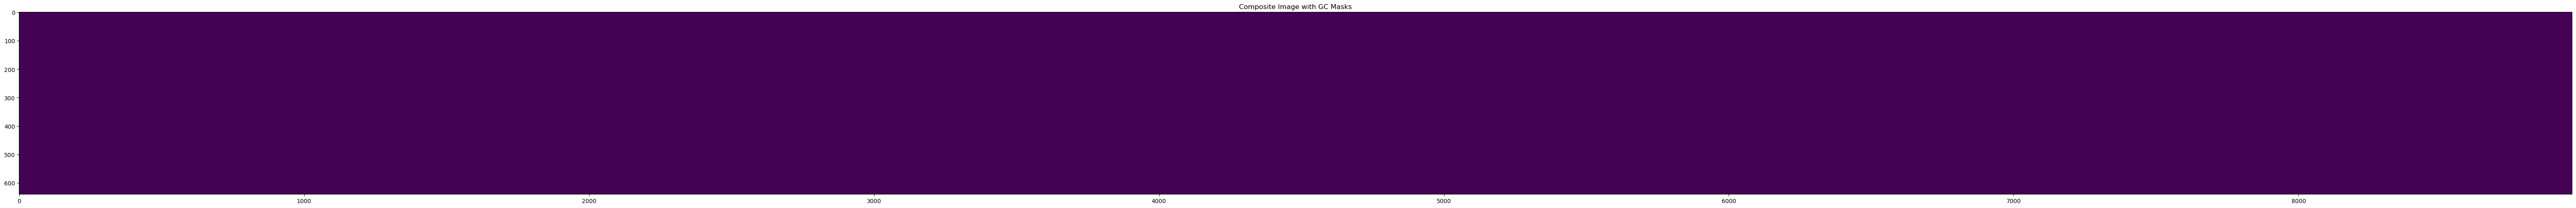

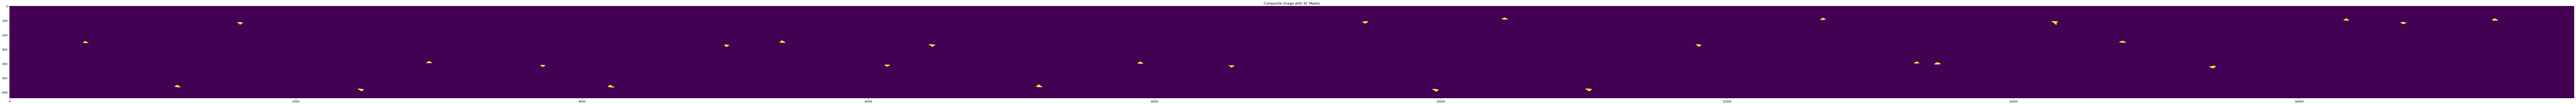

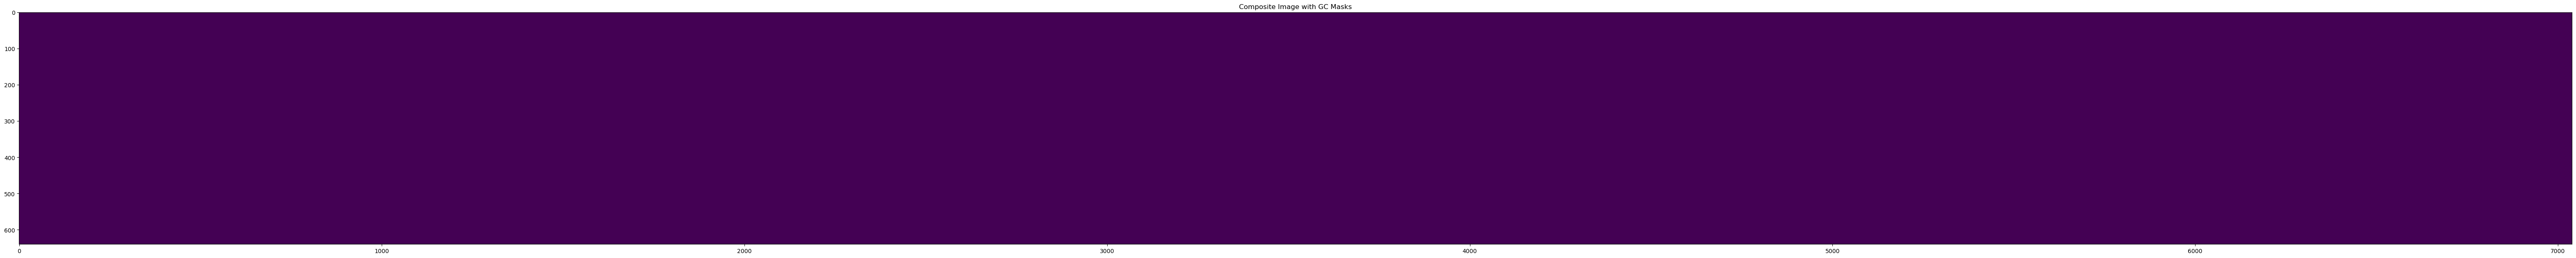

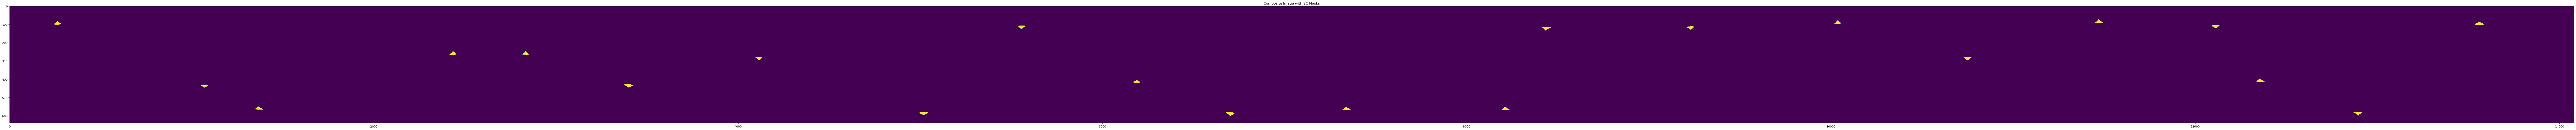

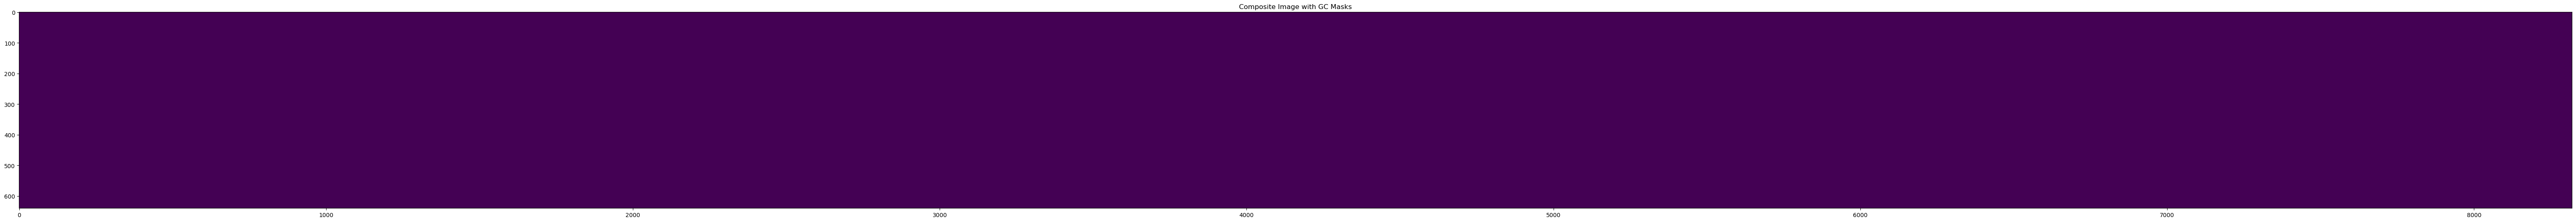

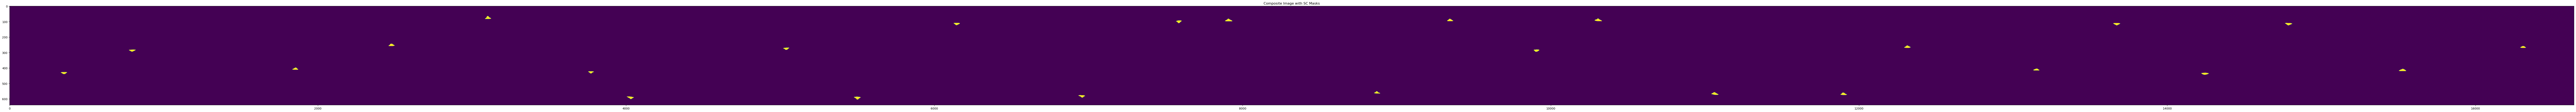

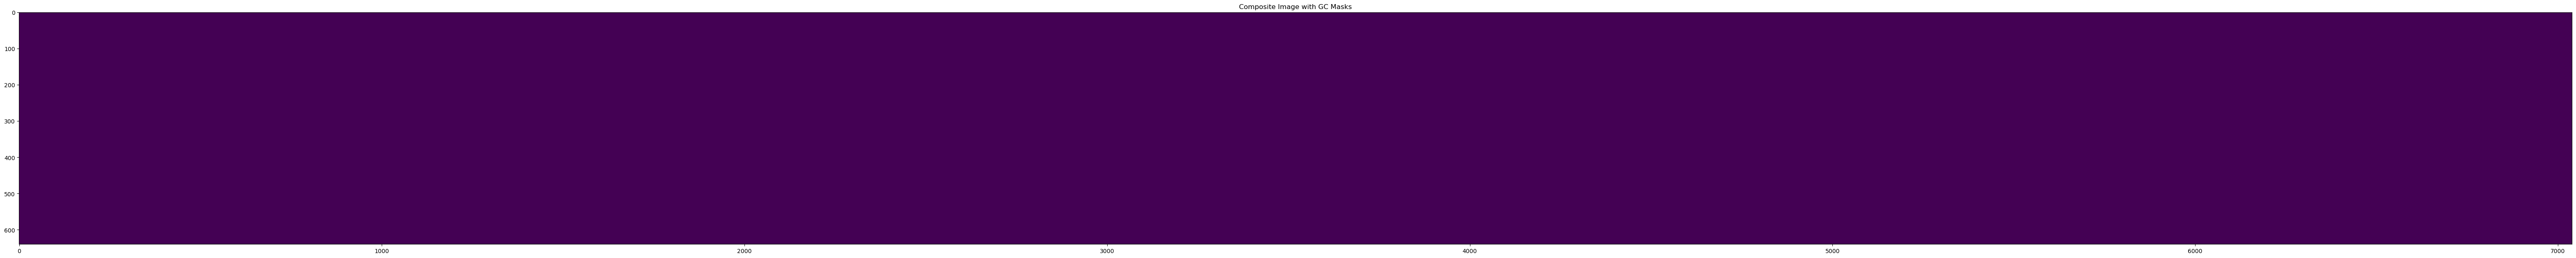

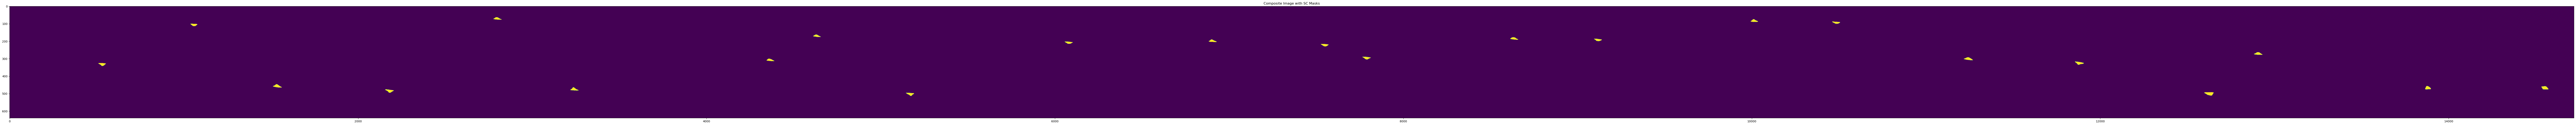

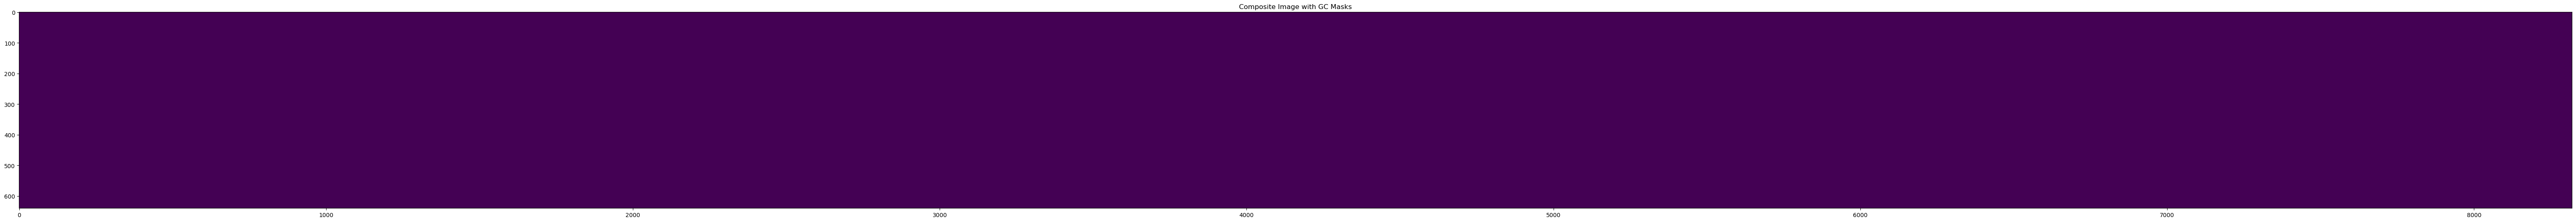

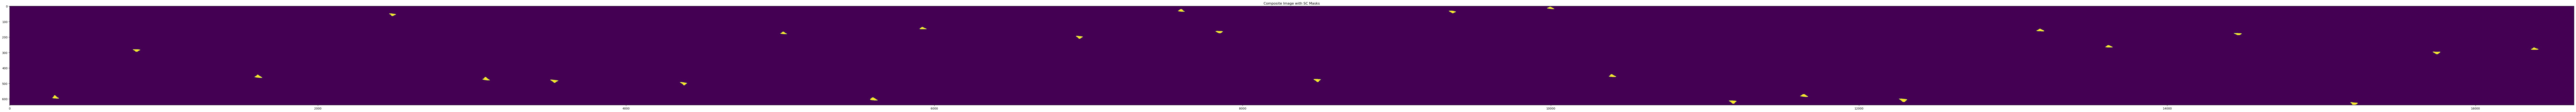

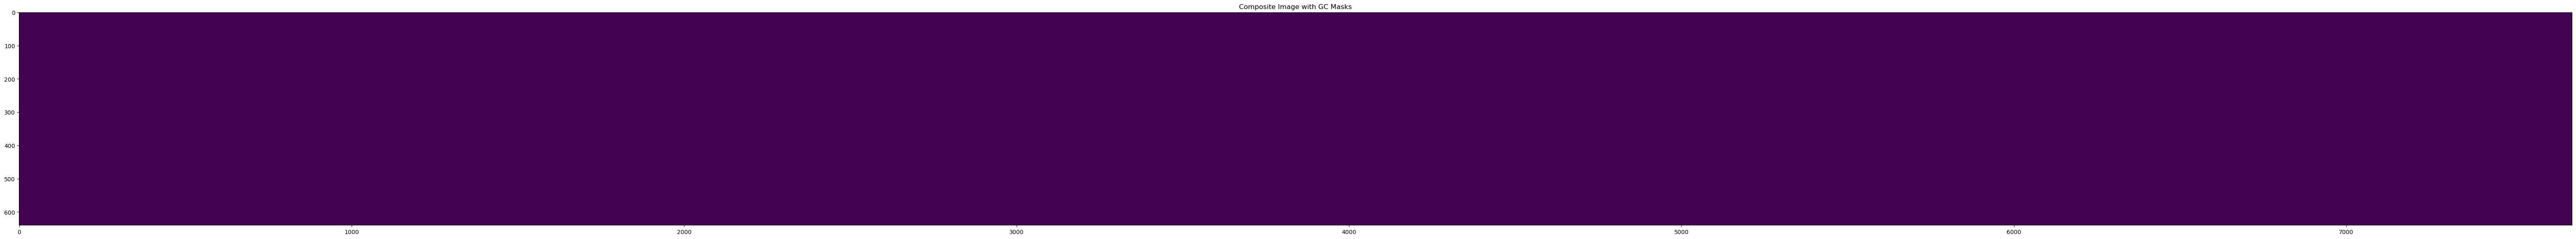

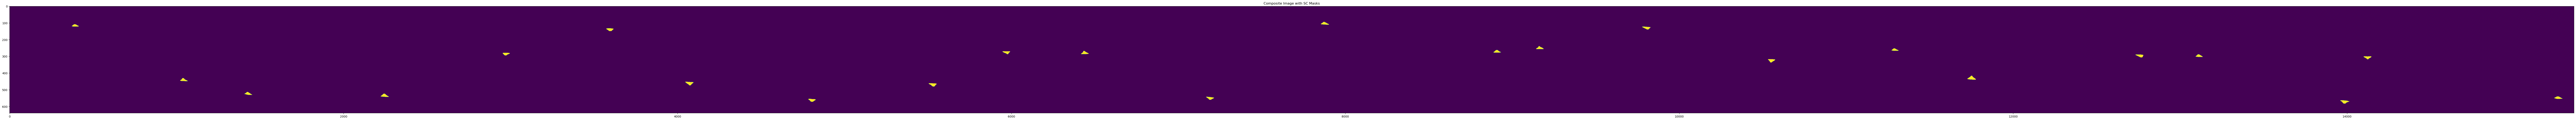

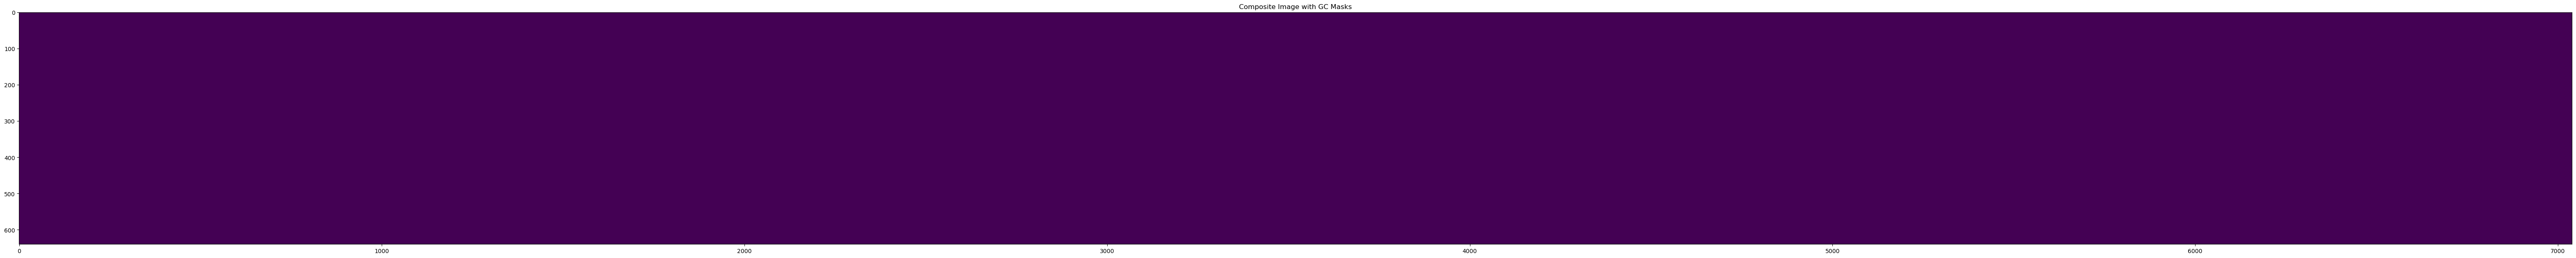

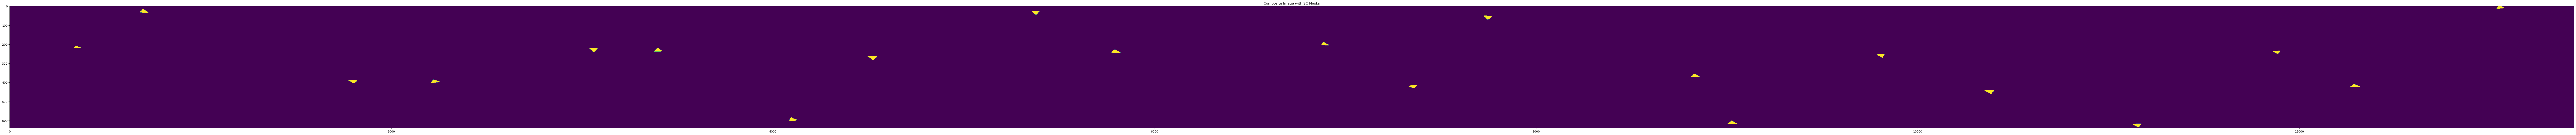

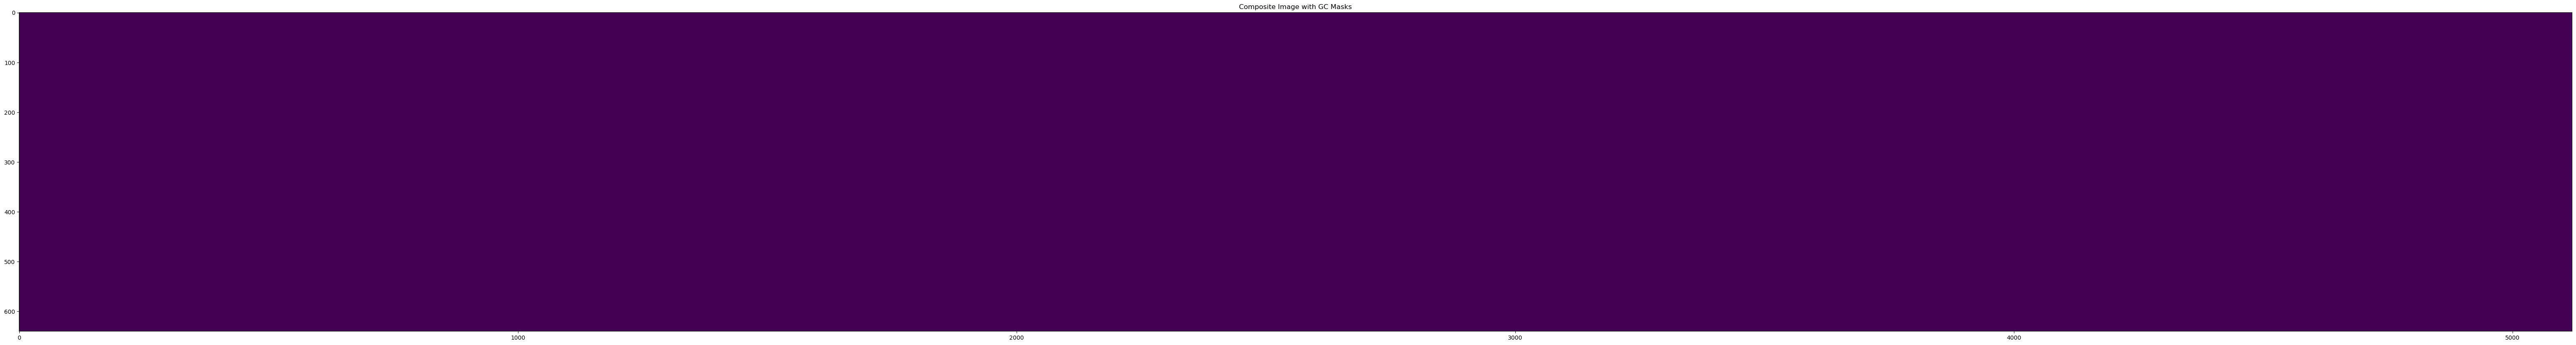

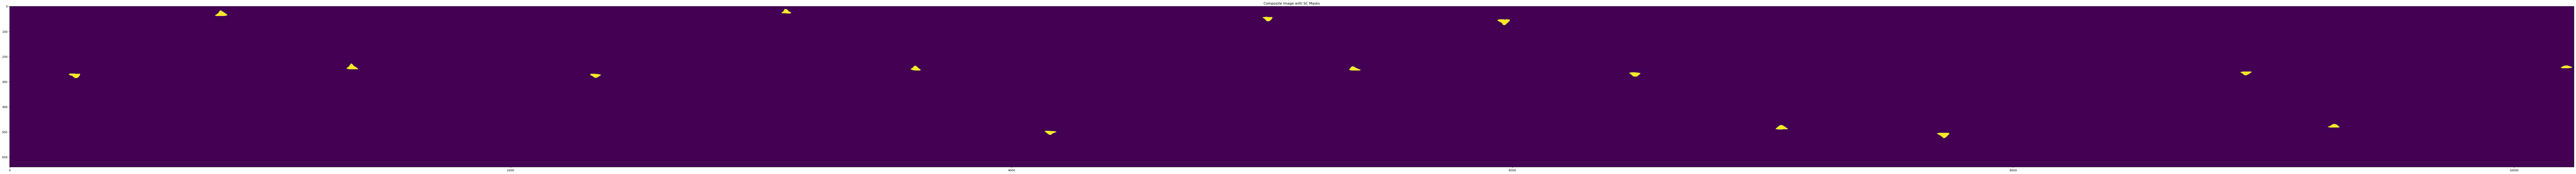

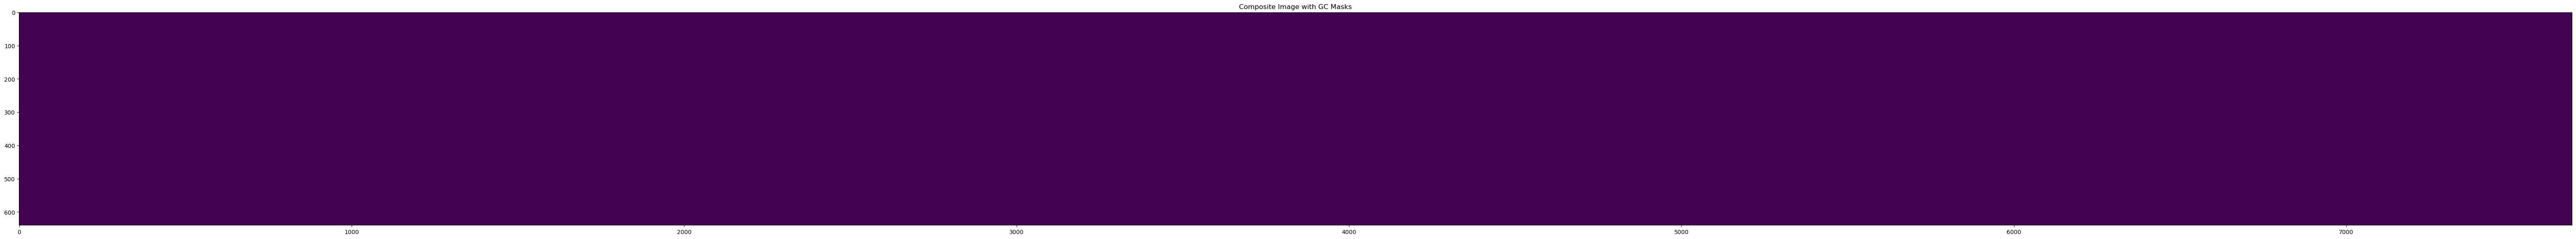

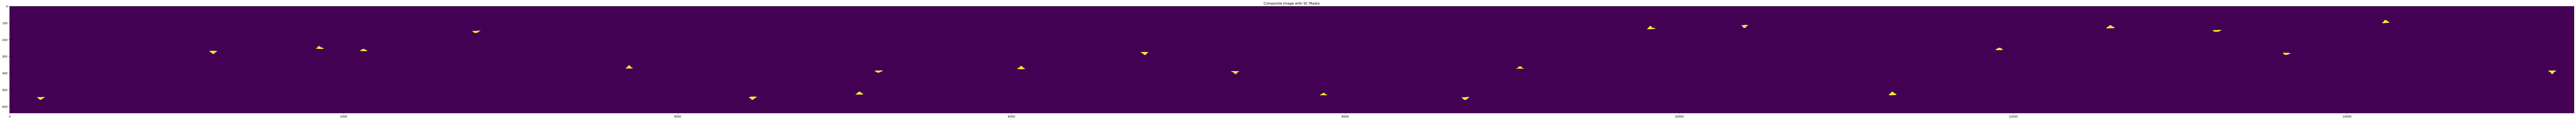

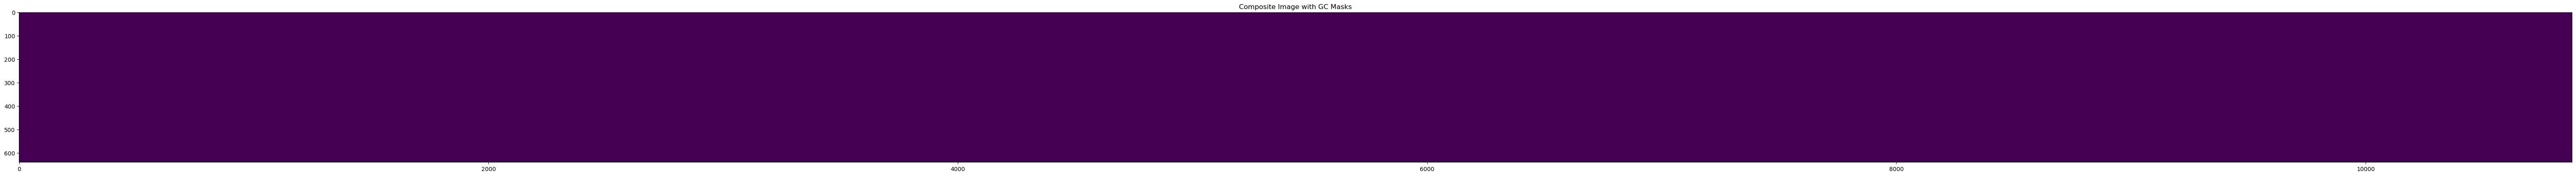

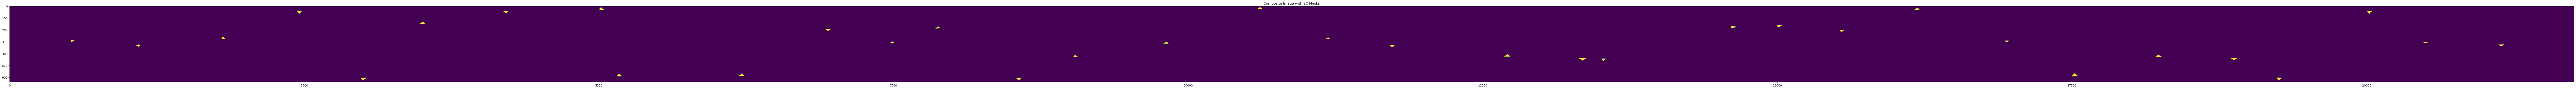

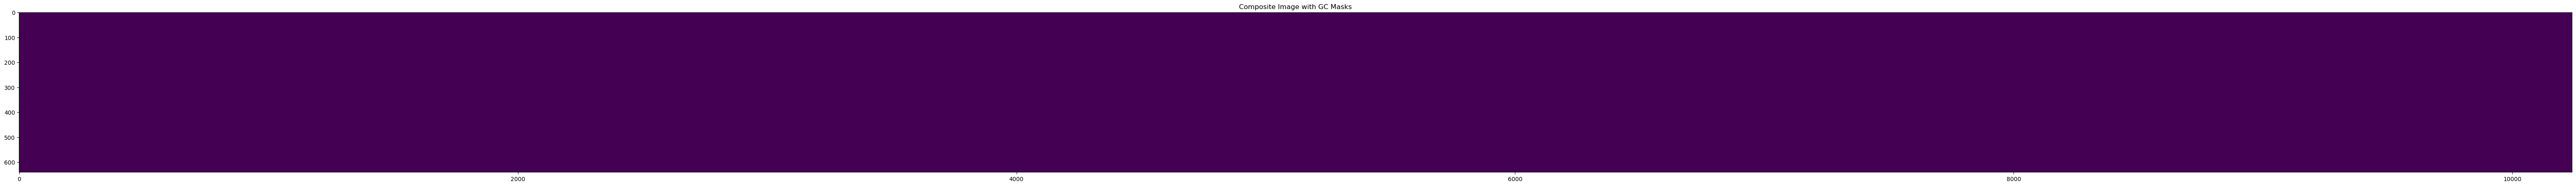

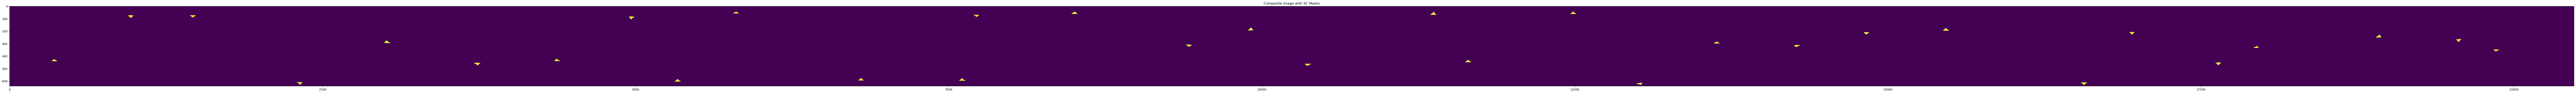

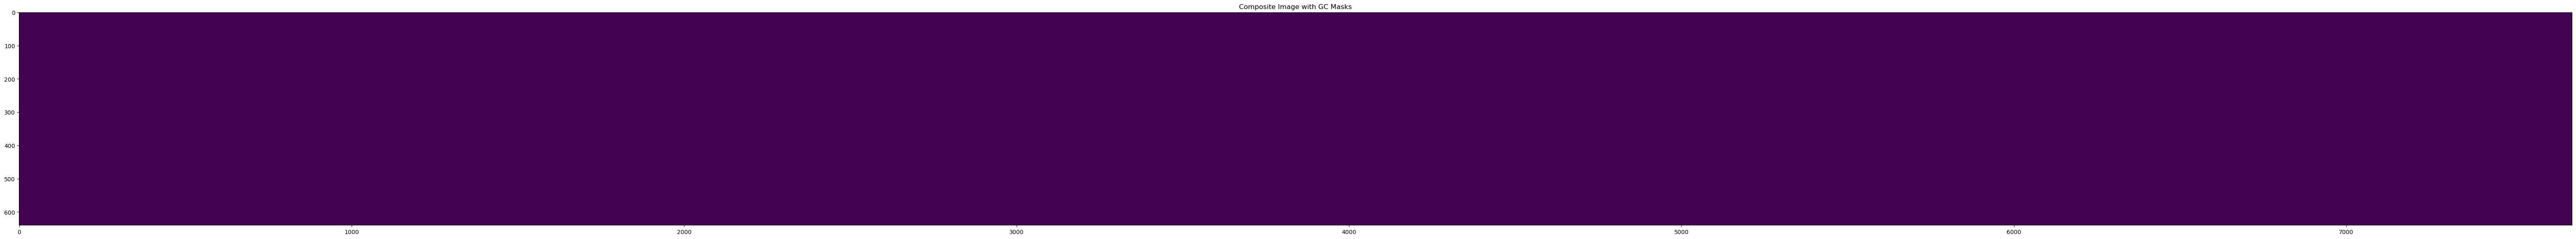

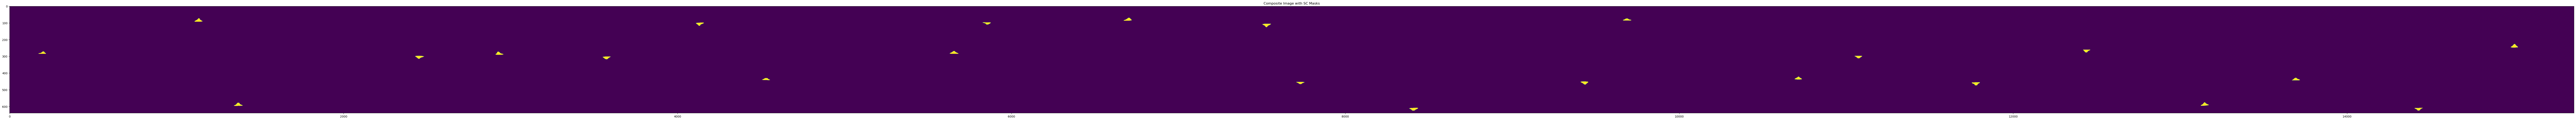

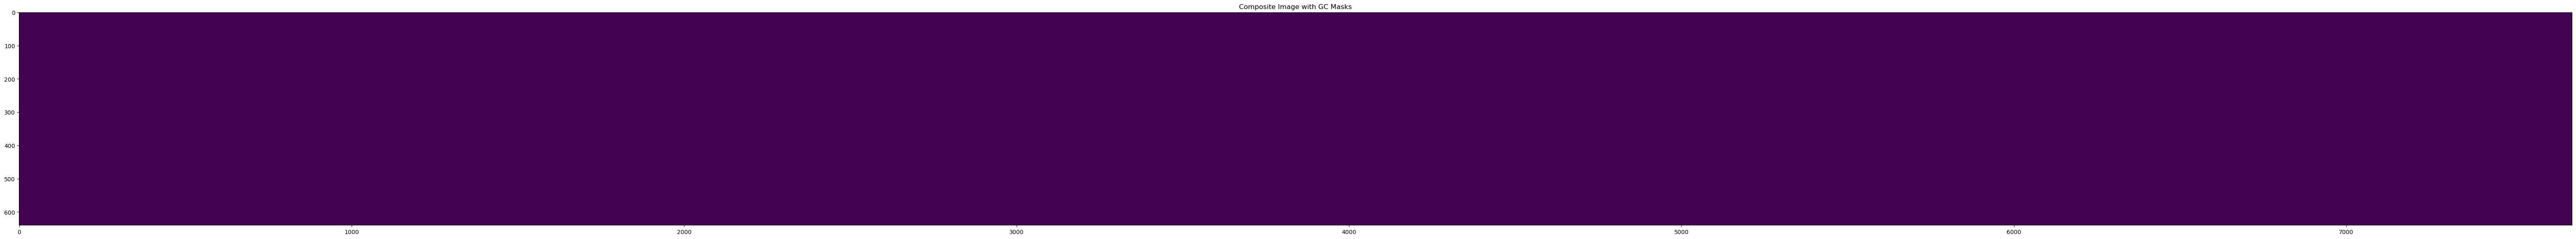

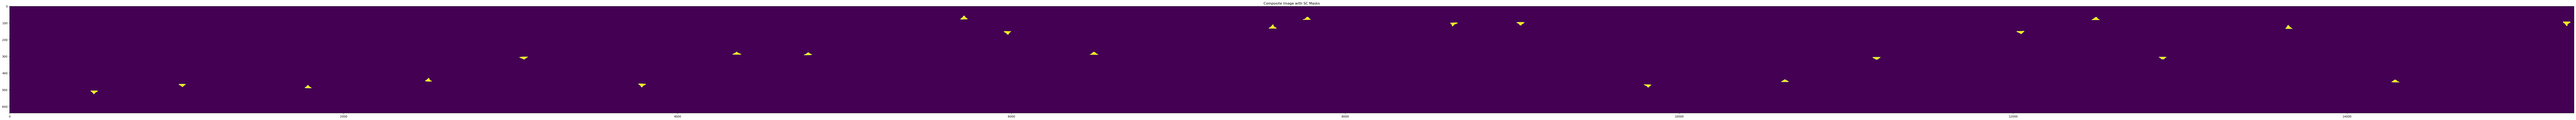

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'predictions' containing 'pred_boxes', 'scores', 'pred_classes', and 'pred_masks'
for predictions in output_lists:
# Extract information from 'predictions'
    pred_boxes = predictions['instances'].pred_boxes.tensor.cpu().numpy()
    scores = predictions['instances'].scores.cpu().numpy()
    pred_classes = predictions['instances'].pred_classes.cpu().numpy()
    pred_masks = predictions['instances'].pred_masks.cpu().numpy()
    Genotype = predictions['genotype']
# Filter by class (assuming class IDs 1 for GC and 2 for SC)
    gc_indices = np.where(pred_classes == 1)[0]
    sc_indices = np.where(pred_classes == 2)[0]

# Determine the overall dimensions of the composite images for GC and SC
    max_height_gc = max(mask.shape[0] for i, mask in enumerate(pred_masks) if i in gc_indices)
    max_height_sc = max(mask.shape[0] for i, mask in enumerate(pred_masks) if i in sc_indices)
    total_width_gc = sum(mask.shape[1] for i, mask in enumerate(pred_masks) if i in gc_indices)
    total_width_sc = sum(mask.shape[1] for i, mask in enumerate(pred_masks) if i in sc_indices)

# Create blank canvases for GC and SC
    composite_image_gc = np.zeros((max_height_gc, total_width_gc), dtype=np.uint8)
    composite_image_sc = np.zeros((max_height_sc, total_width_sc), dtype=np.uint8)

# Overlay each SC mask on the composite image_sc
    current_width_sc = 0
    for i, mask in enumerate(pred_masks):
        if i in sc_indices:
            composite_image_sc[:mask.shape[0], current_width_sc:current_width_sc + mask.shape[1]] = mask
            current_width_sc += mask.shape[1]

# Display the composite images for GC and SC in two separate figures with larger sizes
    plt.figure(figsize=(80, 40))

    plt.subplot(2, 1, 1)
    plt.imshow(composite_image_gc, cmap='viridis')
    plt.title("Composite Image with GC Masks")

    plt.figure(figsize=(160, 80))
    plt.subplot(2, 1, 2)
    plt.imshow(composite_image_sc, cmap='viridis')
    plt.title("Composite Image with SC Masks")
    plt.show()
   

In [15]:
evaluator = COCOEvaluator("guard_valid", cfg, False, output_dir="eval_output/")

val_loader = build_detection_test_loader(cfg, "guard_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [11/20 19:03:47 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/20 19:03:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/20 19:03:47 d2.data.datasets.coco]: Loaded 5 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg3/valid/_annotations.coco.json
[11/20 19:03:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/20 19:03:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/20 19:03:47 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[11/20 19:03:47 d2.data.common]: Serialized dataset takes 0.03 MiB
[11/20 19:03:47 d2.evaluation.evalu